## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [18]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
__________

In [19]:
results={}
factor_value = [0.5, 0.1]
for i in factor_value:
    reduce_lr = ReduceLROnPlateau(factor= i, min_lr=1e-12, monitor='val_loss', patience= 5, verbose=1)
    optimizer = keras.optimizers.SGD(lr=0.001, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = f"factor_value_{i}"
    results[exp_name_tag] = {'train_loss': train_loss,
                            'valid_loss':valid_loss,
                            'train_acc':train_acc,
                            'valid_acc':valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.2282 - acc: 0.2679 - val_loss: 2.1420 - val_acc: 0.3118
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7540 - acc: 0.3923 - val_loss: 1.8344 - val_acc: 0.3767
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6230 - acc: 0.4310 - val_loss: 1.7118 - val_acc: 0.4051
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.5500 - acc: 0.4585 - val_loss: 1.6364 - val_acc: 0.4244
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4955 - acc: 0.4777 - val_loss: 1.5974 - val_acc: 0.4410
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4487 - acc: 0.4941 - val_loss: 1.5735 - val_acc: 0.4489
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.4097 - acc: 0.5089 - val_loss: 1.5526 - val_acc


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6773 - acc: 0.7864 - val_loss: 1.5459 - val_acc: 0.4941
Epoch 8/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.6378 - acc: 0.8058 - val_loss: 1.5323 - val_acc: 0.5022
Epoch 9/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6245 - acc: 0.8151 - val_loss: 1.5348 - val_acc: 0.5003
Epoch 10/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.6206 - acc: 0.8162 - val_loss: 1.5348 - val_acc: 0.5010
Epoch 11/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6173 - acc: 0.8166 - val_loss: 1.5358 - val_acc: 0.5046

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 12/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.6136 - acc: 0.8192 - val_loss: 1.5376 - val_acc: 0.5016
Epoch 13/50

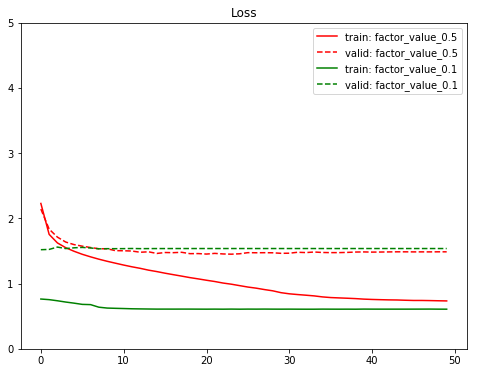

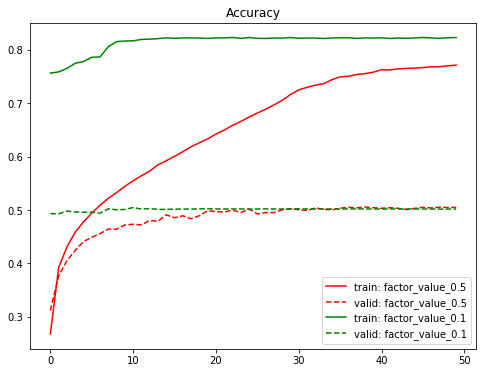

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [21]:
results={}
patience_value = [5, 10]
for i in patience_value:
    reduce_lr = ReduceLROnPlateau(factor= 0.5, min_lr=1e-12, monitor='val_loss', patience= i, verbose=1)
    optimizer = keras.optimizers.SGD(lr=0.001, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = f"patience_value_{i}"
    results[exp_name_tag] = {'train_loss': train_loss,
                            'valid_loss':valid_loss,
                            'train_acc':train_acc,
                            'valid_acc':valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.6415 - acc: 0.8042 - val_loss: 1.5874 - val_acc: 0.5041
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.6334 - acc: 0.8048 - val_loss: 1.5741 - val_acc: 0.4960
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.6173 - acc: 0.8121 - val_loss: 1.5921 - val_acc: 0.4911
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.6002 - acc: 0.8183 - val_loss: 1.5925 - val_acc: 0.5007
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5835 - acc: 0.8251 - val_loss: 1.6299 - val_acc: 0.4904
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.5664 - acc: 0.8325 - val_loss: 1.6205 - val_acc: 0.4990
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5493 - acc: 0.8394 - val_loss: 1.6182 - val_acc

50000/50000 [==============================] - 2s 48us/step - loss: 0.4042 - acc: 0.8959 - val_loss: 1.7595 - val_acc: 0.4936
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3913 - acc: 0.9004 - val_loss: 1.7743 - val_acc: 0.4892
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.3773 - acc: 0.9076 - val_loss: 1.7972 - val_acc: 0.4840
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3656 - acc: 0.9111 - val_loss: 1.8295 - val_acc: 0.4861
Epoch 8/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3501 - acc: 0.9172 - val_loss: 1.8155 - val_acc: 0.4848
Epoch 9/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3371 - acc: 0.9220 - val_loss: 1.8397 - val_acc: 0.4855
Epoch 10/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.3234 - acc: 0.9275 - val_loss: 1.8524 - val_acc: 0.4878
Epoch 11/50
50000/50000 [==========================

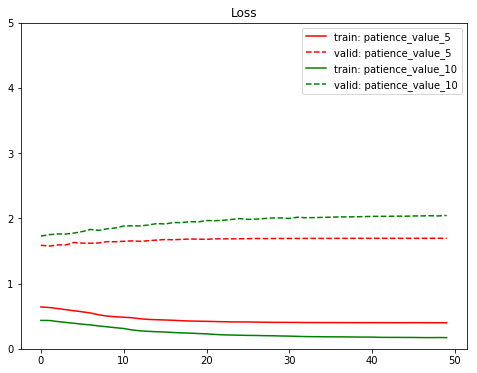

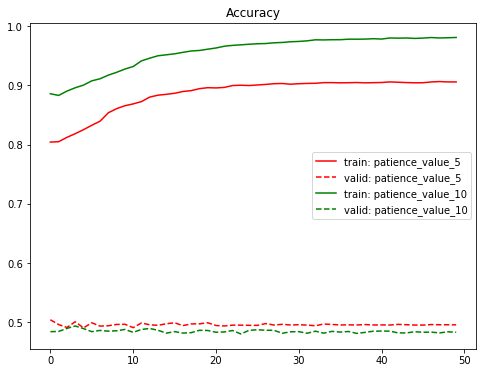

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [16]:
results={}
optimizer_value = ['Adam', 'RMSprop']
for i in optimizer_value:
    reduce_lr = ReduceLROnPlateau(factor= 0.5, min_lr=1e-12, monitor='val_loss', patience= 5, verbose=1)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=i)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = f"optimizer_value{i}"
    results[exp_name_tag] = {'train_loss': train_loss,
                            'valid_loss':valid_loss,
                            'train_acc':train_acc,
                            'valid_acc':valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.8459 - acc: 0.4170 - val_loss: 5.2437 - val_acc: 0.2375
Epoch 2/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.4490 - acc: 0.4892 - val_loss: 2.5578 - val_acc: 0.3432
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.3420 - acc: 0.5293 - val_loss: 3.1417 - val_acc: 0.2924
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2553 - acc: 0.5581 - val_loss: 2.8203 - val_acc: 0.2813
Epoch 5/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.1892 - acc: 0.5813 - val_loss: 2.1955 - val_acc: 0.3624
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.1379 - acc: 0.5972 - val_loss: 2.4641 - val_acc: 0.3276
Epoch 7/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.0859 - acc: 0.6164 - val_loss: 1.9667 - val_acc

50000/50000 [==============================] - 2s 49us/step - loss: 0.8305 - acc: 0.7043 - val_loss: 3.4596 - val_acc: 0.3029
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.7955 - acc: 0.7171 - val_loss: 3.2928 - val_acc: 0.2991
Epoch 7/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.7551 - acc: 0.7327 - val_loss: 3.1285 - val_acc: 0.3035
Epoch 8/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.7311 - acc: 0.7412 - val_loss: 2.2186 - val_acc: 0.3976
Epoch 9/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.6975 - acc: 0.7536 - val_loss: 3.1174 - val_acc: 0.2957
Epoch 10/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.6845 - acc: 0.7582 - val_loss: 2.6395 - val_acc: 0.3314
Epoch 11/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.6669 - acc: 0.7637 - val_loss: 4.1821 - val_acc: 0.2872
Epoch 12/50
50000/50000 [=========================

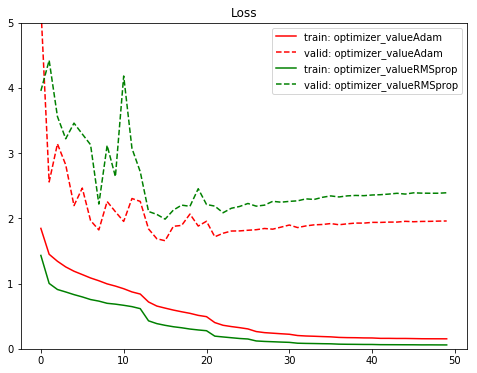

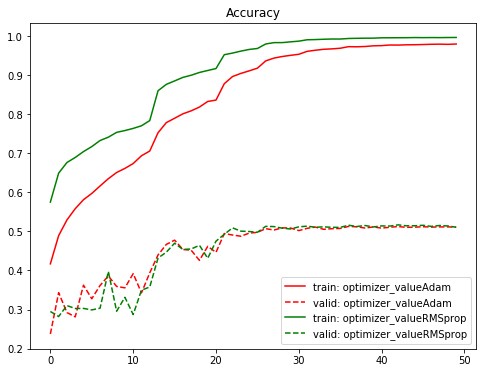

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()